In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizerFast

In [2]:
df = pd.read_csv('admin2.csv')
df.head()

,id,text,label,Comments
0,7789,@AAlwuhaib1977 Muslim mob violence against Hin...,racism,NaN
1,7790,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,normal,NaN
2,7791,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism,NaN
3,7792,"Finally I'm all caught up, and that sudden dea...",normal,NaN
4,7793,@carolinesinders @herecomesfran *hugs*,normal,NaN


In [3]:
print("Number of missing values in each column:")
print(df.isna().sum())


Number of missing values in each column:
id             0
text           0
label          1
Comments    4055
dtype: int64


In [4]:
df.fillna(value=df.mode().iloc[0], inplace=True)
print("Number of missing values in each column:")
print(df.isna().sum())

Number of missing values in each column:
id             0
text           0
label          0
Comments    4055
dtype: int64


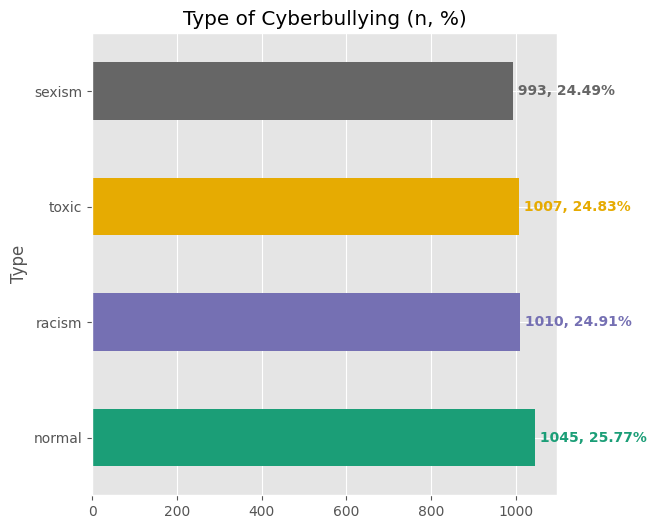

In [5]:

plt.style.use('ggplot')

num_classes = len(df["label"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df['label'].value_counts().plot.barh(title="Type of Cyberbullying (n, %)",
                                                 ylabel="Type",
                                                 color=colors,
                                                 figsize=(6,6))

for i, v in enumerate(df['label'].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%",
           color=c,
           va='center',
           fontweight='bold')

In [6]:
df['Types'] = df['label'].map({'racism': 0,
                                            'sexism': 1,
                                            'toxic': 2,
                                            'normal': 3
                                            })

# drop unused column
df = df.drop(["label"], axis=1)

df.head()


,id,text,Comments,Types
0,7789,@AAlwuhaib1977 Muslim mob violence against Hin...,NaN,0
1,7790,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,NaN,3
2,7791,@jncatron @isra_jourisra @AMPalestine Islamoph...,NaN,0
3,7792,"Finally I'm all caught up, and that sudden dea...",NaN,3
4,7793,@carolinesinders @herecomesfran *hugs*,NaN,3


In [7]:
#df['Text'] = df['text'].apply(preprocess_text)
df['Text'] = df['text']
df.head()

,id,text,Comments,Types,Text
0,7789,@AAlwuhaib1977 Muslim mob violence against Hin...,NaN,0,@AAlwuhaib1977 Muslim mob violence against Hin...
1,7790,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,NaN,3,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG
2,7791,@jncatron @isra_jourisra @AMPalestine Islamoph...,NaN,0,@jncatron @isra_jourisra @AMPalestine Islamoph...
3,7792,"Finally I'm all caught up, and that sudden dea...",NaN,3,"Finally I'm all caught up, and that sudden dea..."
4,7793,@carolinesinders @herecomesfran *hugs*,NaN,3,@carolinesinders @herecomesfran *hugs*


In [8]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [9]:
#x_train, x_test, y_train, y_test = train_test_split(df['text'], df['Types'], test_size=0.20)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['Types'], test_size=0.20)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train_one_hot = label_binarizer.fit_transform(y_train)
y_test_one_hot = label_binarizer.transform(y_test)


In [ ]:
!pip install tensorflow-text

In [12]:
import tensorflow_hub as hub
import tensorflow_text as text


In [13]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
bert_preprocess_model = hub.KerasLayer(preprocess_url)
bert_encoder_model = hub.KerasLayer(encoder_url)

In [ ]:
def get_embeddings(sentences):
    preprocessed_text = bert_preprocess_model(sentences)
    return bert_encoder_model(preprocessed_text)['pooled_output']

embeddings = get_embeddings([
    "Muslim mob violence against Hindus in Bangladesh continues in 2014."
    "Does N.e.bodyelse Hear her Crazy ass Screamin ,HOE, everytime she say's Stupid Hoe .. Lol. did n.e.body see Chris Browns face at 2:04 wen Nicki was touchin him If"
    "=stop ur stupid invlovment===="
    "We still do, as well as underestimating the judging #MKR"

])

print(embeddings)

In [15]:

def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = cosine_similarity(features)
  fig = plt.figure(figsize=(10,8))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Blues",
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

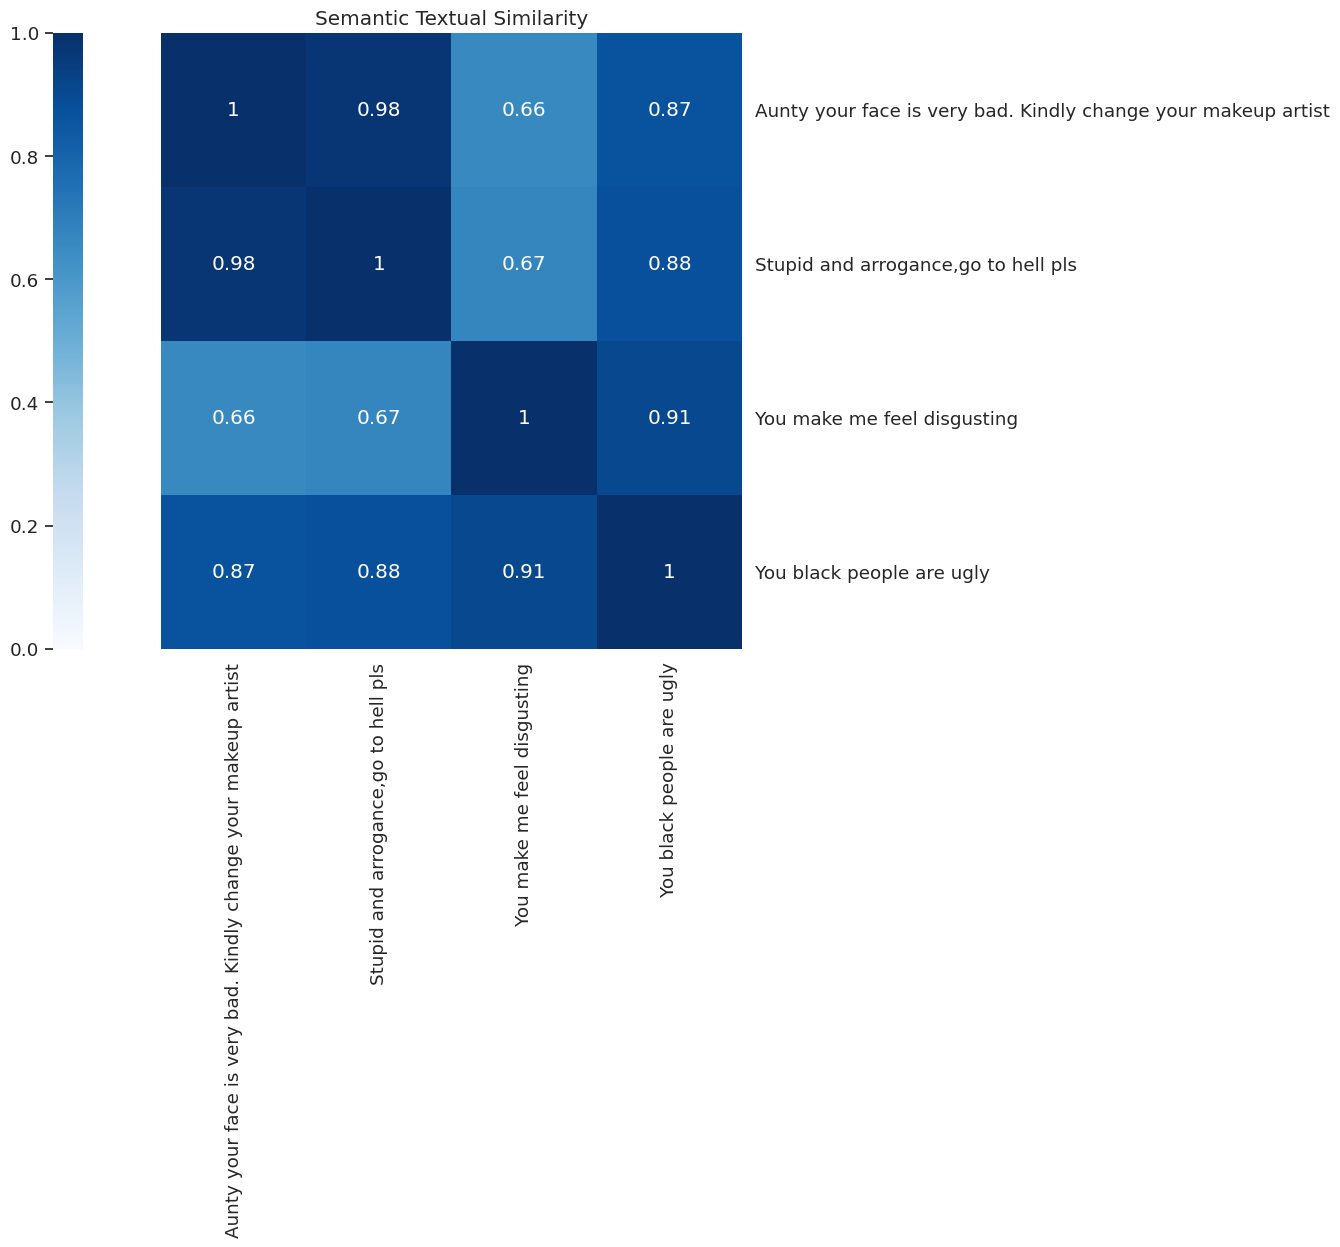

In [16]:
cmnts = [
    'Aunty your face is very bad. Kindly change your makeup artist',
    'Stupid and arrogance,go to hell pls',
    'You make me feel disgusting',
    'You black people are ugly'

]
plot_similarity(get_embeddings(cmnts), cmnts)

In [17]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):

    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):

    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [18]:
num_classes = 4
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = bert_preprocess_model(i)
x = bert_encoder_model(x)
x = tf.keras.layers.Dropout(0.5, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)
model = tf.keras.Model(i, x)

In [19]:
n_epochs = 30

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train,
                      y_train_one_hot,
                      epochs = n_epochs,
                      validation_data = (x_test, y_test_one_hot))
                     # callbacks = [earlystop_callback])

Epoch 1/30
102/102 [==============================] - 53s 416ms/step - loss: 1.2885 - accuracy: 0.4285 - balanced_recall: 0.2924 - balanced_precision: 0.4533 - balanced_f1_score: 0.3474 - val_loss: 1.0544 - val_accuracy: 0.5882 - val_balanced_recall: 0.3154 - val_balanced_precision: 0.3772 - val_balanced_f1_score: 0.3370
Epoch 2/30
102/102 [==============================] - 41s 405ms/step - loss: 1.0957 - accuracy: 0.5351 - balanced_recall: 0.4045 - balanced_precision: 0.5733 - balanced_f1_score: 0.4708 - val_loss: 0.9890 - val_accuracy: 0.5980 - val_balanced_recall: 0.4679 - val_balanced_precision: 0.5219 - val_balanced_f1_score: 0.4885
Epoch 3/30
102/102 [==============================] - 42s 415ms/step - loss: 1.0442 - accuracy: 0.5684 - balanced_recall: 0.4341 - balanced_precision: 0.5987 - balanced_f1_score: 0.4996 - val_loss: 0.9578 - val_accuracy: 0.6128 - val_balanced_recall: 0.4163 - val_balanced_precision: 0.6838 - val_balanced_f1_score: 0.5132
Epoch 4/30
102/102 [===========

In [20]:
evaluation_results = model.evaluate(x_train, y_train_one_hot)
total_accuracy = evaluation_results[model.metrics_names.index('accuracy')]

print(f'Total Accuracy: {total_accuracy * 100:.2f}%')


102/102 [==============================] - 32s 310ms/step - loss: 0.6743 - accuracy: 0.7491 - balanced_recall: 0.6665 - balanced_precision: 0.8077 - balanced_f1_score: 0.7284
Total Accuracy: 74.91%


In [21]:
evaluation_results = model.evaluate(x_test, y_test_one_hot)
total_accuracy = evaluation_results[model.metrics_names.index('accuracy')]

print(f'Total Accuracy: {total_accuracy * 100:.2f}%')


26/26 [==============================] - 8s 297ms/step - loss: 0.7320 - accuracy: 0.7139 - balanced_recall: 0.6460 - balanced_precision: 0.7483 - balanced_f1_score: 0.6918
Total Accuracy: 71.39%


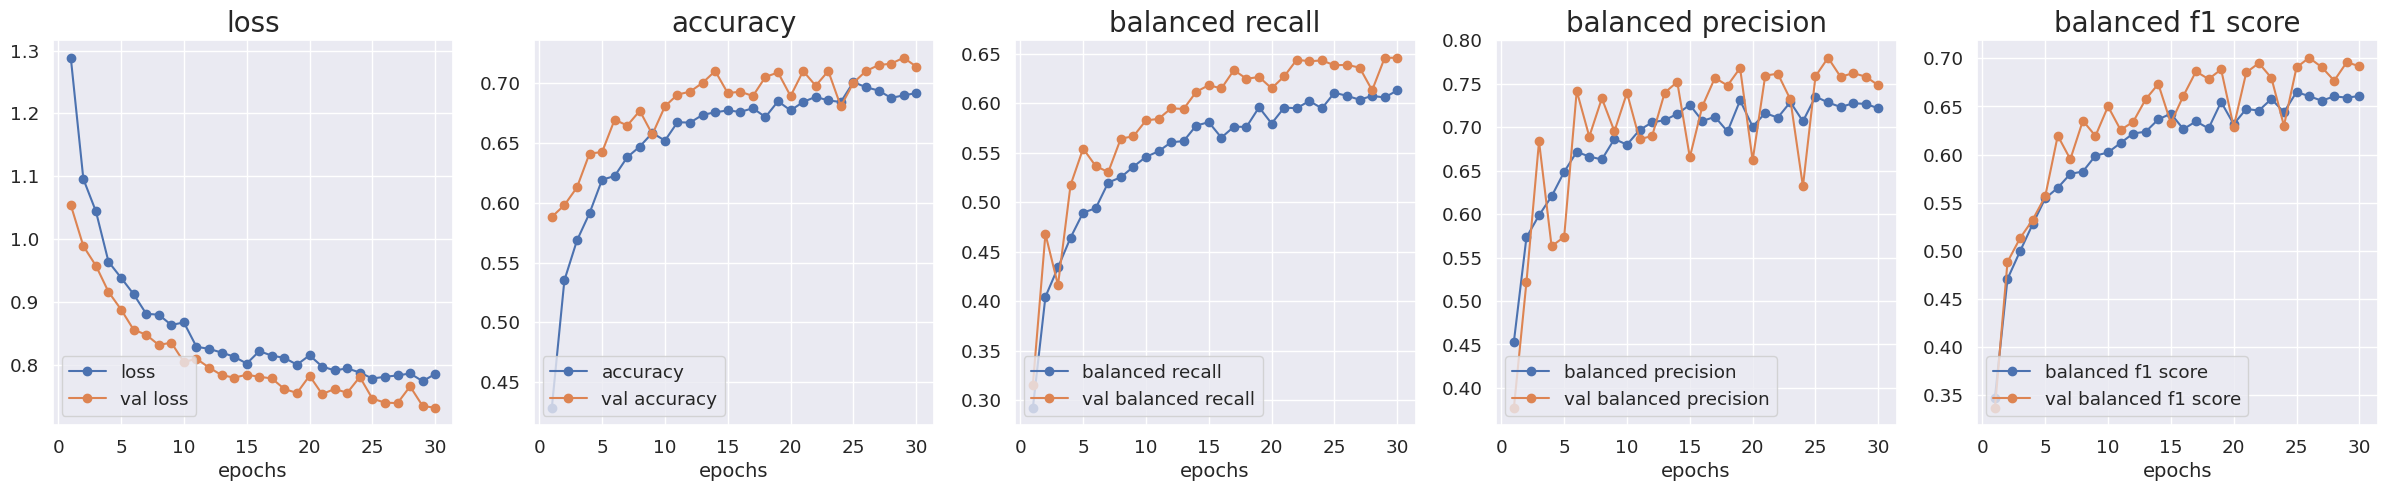

In [22]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [23]:
comments = [
    "You make me feel disgusting",
    "She is so ugly. I don't like her face",
    "Go kill yourself.",
    "You are pretty"

]


In [24]:
def predict_class(comments):
    predicted_probabilities = model.predict(comments)
    predicted_classes = np.argmax(predicted_probabilities, axis=1)

    return predicted_classes


predicted_classes = predict_class(comments)
print(predicted_classes)

1/1 [==============================] - 1s 737ms/step
[3 1 3 3]


In [25]:
y_predicted_probabilities = model.predict(x_test)
y_predicted_classes = np.argmax(y_predicted_probabilities, axis=1)

26/26 [==============================] - 8s 304ms/step


In [26]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_predicted_classes)
classification_rep = classification_report(np.argmax(y_test_one_hot, axis=1), y_predicted_classes)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_rep)

Confusion Matrix:
[[171  11   5  12]
 [ 15 136   9  35]
 [  3   1 161  23]
 [ 28  45  45 111]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       199
           1       0.70      0.70      0.70       195
           2       0.73      0.86      0.79       188
           3       0.61      0.48      0.54       229

    accuracy                           0.71       811
   macro avg       0.71      0.72      0.71       811
weighted avg       0.71      0.71      0.71       811



Text(43.25, 0.5, 'Truth')

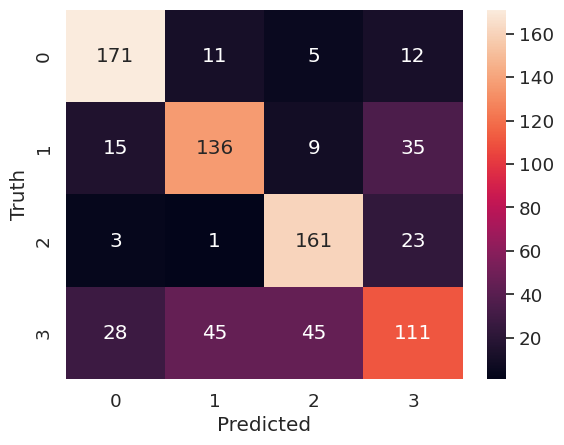

In [27]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')